#NEED TO SAMPLE THE FILE TO DEVELOP 
awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01 || FNR==1) print $0}' filename


In [73]:
!pwd


/home/dliu/lambda/unit-2/DS-Unit-2-Build-dmhliu


In [74]:
import pandas as pd
import numpy as np
import math 

pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 100)


In [75]:
# Get Pandas Profiling Report
import pandas_profiling
#pandas_profiling.ProfileReport(df)

In [76]:
df = pd.read_csv('reduced1.csv', header=0, error_bad_lines=False, engine="python");

e 30657: ',' expected after '"'
Skipping line 30660: ',' expected after '"'
Skipping line 30683: ',' expected after '"'
Skipping line 30689: ',' expected after '"'
Skipping line 30697: ',' expected after '"'
Skipping line 30725: ',' expected after '"'
Skipping line 30748: ',' expected after '"'
Skipping line 30749: ',' expected after '"'
Skipping line 30758: ',' expected after '"'
Skipping line 30765: ',' expected after '"'
Skipping line 30783: ',' expected after '"'
Skipping line 30805: ',' expected after '"'
Skipping line 30879: ',' expected after '"'
Skipping line 30895: ',' expected after '"'
Skipping line 30900: ',' expected after '"'
Skipping line 30919: ',' expected after '"'
Skipping line 30924: ',' expected after '"'
Skipping line 30939: ',' expected after '"'
Skipping line 30995: ',' expected after '"'
Skipping line 31030: ',' expected after '"'
Skipping line 31039: ',' expected after '"'
Skipping line 31044: ',' expected after '"'
Skipping line 31045: ',' expected after '"'


In [77]:
columns = df.columns
str_cols = df.select_dtypes('object').columns


In [78]:
delete = [s for s in df.columns.values if 'DELETE - ' in s]   #columns have delete in name
boundary = [s for s in df.columns.values if 'Boundary' in s]   #columns have boundary in name
floatcols = df.select_dtypes(include='float64').columns


In [79]:
class wrangler:
    #class vars
    dropcols = list() #list to store columns to drop
    droprows = dict() #row boolean filters
    dropcols_post = list()
    bool_filters = dict() # list of name, expression tuples , or dict?

    encoders = dict() # colname, function to be applied to elements
    def calc_lt_005_cat(self, df): 
        return df.Category.value_counts()[df.Category.value_counts(normalize=True).values < .005]

    def __init__(self, data):
        self.raw_df = data.copy()  
        self.working = self.raw_df.copy()
    #methods
    def set_data(self,df):          # reset dataframe to new df
        print('set data to df', df.shape)
        self.raw_df= df.copy()
        self.working = self.raw_df.copy()
        return working
    def add_to_dropcols(self,labels):
        for l in labels:
            if l in self.dropcols:
                print('error column already in dropcols list')
                break
                return self.dropcols
        self.dropcols.extend(labels)
        return self.dropcols

    def get_dropcols(self):
        if not self.dropcols: 
            print('no columns to drop')
        return self.dropcols
    def clear_dropcols(self):
        self.dropcols=list()
        return True
    def get_nancols(self, df=None, store=False):
        if df is None: 
            df=self.working
        cols =df.columns
        nc=df[cols].isnull().sum().index.tolist()
        if store:
            self.nancols = nc
        return nc
    def add_to_droprows(self, name, expr):
        self.droprows[name] = expr 
        return self.droprows

    def get_params(self):
        pass
        #return all wrangler settings 
    def set_nanval(self):
        pass 
       # self.nanvals add self to 
    def add_bool_filter(self, label, expr):  #
        self.bool_filters[label] = expr
        return self.bool_filters
    def add_encoding(self, label, mapper):
        try:
            label in self.working.columns
        except:
            print(label, 'not found in working copy, may have been dropped')
            assert label in self.raw_df.columns
        self.encoders[label]= mapper

#internal 
    def drop_rows_by_mask(self,df=None,labels=None):
        if df is None:
            df=self.working
        if labels is None:
            print('dropping all in droprows..')
            if self.droprows:
                labels = list(self.droprows.keys())
        mask = self.droprows[labels[0]]  #get first boolean mask
        for l in labels: 
            print('\napplying mask: ',l )
            mask = mask | self.droprows[l]   #or them all together
        df.drop(index=df[mask].index,inplace=True)
        
        return df 
    def drop_dupes(self, df=None):
        if df is None:
            df=self.working
        todropindex = df[df.duplicated()].index
        df.drop(todropindex,axis=0, inplace=True)
        return df

    def drop_columns(self,df=None, list=None):
        if df is None:
            df = self.working
        if list is None: 
            list= self.dropcols
        #todo check dropcols present in df.columns
        return df.drop(labels=self.dropcols, axis=1, inplace=True)
    def drop_columns_post(self):
        drop_columns(list=dropcols_post)
    
    def encode(self,df=None):                      
        if df is None: 
            df=self.working
            print('/n Encoding, changing working copy..')
        for k in list(self.encoders.keys()):
            print('/n  ... encoding column: ',k)
            df[k] = df[k].map(self.encoders[k])
        return df
    def to_datetime(self, cols=None, df=None):
        if df is None:
            df=self.working
            print('\nworking df is being changed..')
        if cols is None:
            cols=self.dt_cols
        for c in cols:
            print('converting',c,'to datetime')
            try:
                df[c] = pd.to_datetime(df[c],infer_datetime_format=True)  #inplace 
            except: 
                print('error - possible this column needs cleaning')
        return df

       
    def make_feature(self,newlabel,input,fun):      #make or overwrite column newlabel
        df=self.working
        try:
            df[newlabel] = df[input].apply(fun, axis=1)  #or map or tranform?
            print('\nadded feature:', newlabel)
        except:
            print('there was a problem, not added!!')
            return False
        return True
    

    order_default = [drop_rows_by_mask,
                    drop_columns, 
                    drop_dupes,
                    encode,
                    drop_columns_post]   #list of methods in order of application

    def wrangle(self, df=None):
        if df is None:
            df =self.raw_df.copy() # start from the beginning 
            result = df
            print('will apply :', self.order_default)
            for f in self.order_default:
                print('level')
                result = f(result)
        return result
## instantiate  a wrangler and setup drops and encoding. 
## run methods on the internal working copy to iterate 
## to test entire workflow, run wrangle() with the default to process the orginal data in order defined 
## 

In [80]:
##define settings here 
test = wrangler(df)   
test.clear_dropcols()

test.add_to_dropcols(delete)

test.add_to_dropcols(['Point'])  ##redundant w/ lat long, but may use for geospatial later

missing_to_0 = lambda x : 0 if math.isnan(x) else int(x)   #convert float to int, nan to zeros
test.add_encoding('Analysis Neighborhoods', missing_to_0)  #convert neigborhoods
test.add_encoding('Neighborhoods', missing_to_0) 
##

test.add_encoding('Media URL', lambda x : 'present' if type(x) == str else 'missing')

def caseid_to_int (x):    #convert good caseids to int, bad to zero for drop
    try:
        i = int(x)
    except:
        i = 0   
        return 0      #strings are converted to zero for dropping 
    return i
test.droprows['drop_missing_caseid'] = df.CaseID.map(caseid_to_int) == 0    #mask to drop rows with no caseid

test.add_encoding('CaseID', caseid_to_int)        #can be done any order


In [81]:

##drop 

nopen = df.Opened.isnull()    # bad records 

test.droprows['drop null open date'] = nopen #migh be fixed by  missing caseID?

nclosed= df.Closed.isnull()   # some are really opn
nupdated = df.Updated.isnull()

muni = df.Category== 'MUNI Feedback'   #bus complaints we dont want

test.add_to_droprows('muni', muni);

In [82]:
catcounts = test.working.Category.value_counts()
single =catcounts.values ==1
badcats = catcounts[single].index
badcats = df.Category.isin( badcats)  #mask
test.add_to_droprows('singlecategories', badcats);


In [83]:

hoodcols = list()
for c in df.columns:
    if 'Neighborhood' in c:
        hoodcols.append(c)

dt_cols = ['Opened','Closed','Updated']
test.dt_cols = dt_cols

In [84]:
test.order_default  # this is the order we want to run preprocessing in 

[<function __main__.wrangler.drop_rows_by_mask(self, df=None, labels=None)>,
 <function __main__.wrangler.drop_columns(self, df=None, list=None)>,
 <function __main__.wrangler.drop_dupes(self, df=None)>,
 <function __main__.wrangler.encode(self, df=None)>,
 <function __main__.wrangler.drop_columns_post(self)>]

In [85]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

print('drop rows: ', test.droprows.keys())
pp.pprint( test.dropcols)
print('encode: ', test.encoders.keys())

drop rows:  dict_keys(['drop_missing_caseid', 'drop null open date', 'muni', 'singlecategories'])
[   'DELETE - Supervisor Districts',
    'DELETE - Fire Prevention Districts',
    'DELETE - Current Police Districts',
    'DELETE - Zip Codes',
    'DELETE - Police Districts',
    'DELETE - Neighborhoods',
    'DELETE - Neighborhoods_from_fyvs_ahh9',
    'DELETE - 2017 Fix It Zones',
    'DELETE - SF Find Neighborhoods',
    'DELETE - Current Supervisor Districts',
    'DELETE - HSOC Zones',
    'Point']
encode:  dict_keys(['Analysis Neighborhoods', 'Neighborhoods', 'Media URL', 'CaseID'])


In [111]:
test.dropcols_post=['Point']

test.add_encoding('Category', lambda cat : 'other' if cat in self.calc_lt_005_cat(self.working).index.tolist() else cat)
test.encoders

{'Analysis Neighborhoods': <function __main__.<lambda>(x)>,
 'Neighborhoods': <function __main__.<lambda>(x)>,
 'Media URL': <function __main__.<lambda>(x)>,
 'CaseID': <function __main__.caseid_to_int(x)>,
 'Category': <function __main__.<lambda>(cat)>}

In [87]:
## run  some of the setup functionality 
test.drop_rows_by_mask()
test.drop_dupes()
test.to_datetime();
test.encode();
test.drop_columns(list=test.dropcols_post)
test.make_feature('ttr',['Opened','Closed'],lambda x : x[1]-x[0])

dropping all in droprows..

applying mask:  drop_missing_caseid

applying mask:  drop null open date

applying mask:  muni

applying mask:  singlecategories

working df is being changed..
converting Opened to datetime
converting Closed to datetime
converting Updated to datetime
/n Encoding, changing working copy..
/n  ... encoding column:  Analysis Neighborhoods
/n  ... encoding column:  Neighborhoods
/n  ... encoding column:  Media URL
/n  ... encoding column:  CaseID

added feature: ttr


True

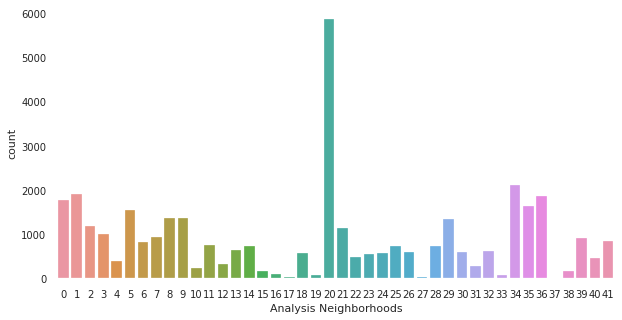

In [88]:
df['Analysis Neighborhoods'].value_counts(normalize=True,dropna=False)
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x='Analysis Neighborhoods',data=test.working)

fig.show()

In [90]:
test.working.ttr.describe()
test.target = 'ttr'


count                       37115
mean      40 days 04:17:30.429960
std      176 days 02:15:35.175401
min            -13 days +16:54:00
25%               0 days 04:10:37
50%               1 days 14:10:00
75%        6 days 22:43:39.500000
max            4269 days 00:36:47
Name: ttr, dtype: object

In [103]:
##look at negativ deltas, 
df = test.working 
neg_ttr = df.ttr.map(lambda td : td.total_seconds() < 0)
df[neg_ttr]['CaseID'].nunique() ,df[neg_ttr].shape       #one record per caseid here




(354, (354, 36))

In [110]:
df.Category.value_counts()
test.calc_lt_005_cat(df).index.tolist()

['General Request - 311CUSTOMERSERVICECENTER',
 'Color Curb',
 'Construction Zone Permits',
 'General Request - DPH',
 'General Request - BUILDING INSPECTION',
 'General Request - ASSESSOR RECORDER',
 'Residential Building Request',
 'Catch Basin Maintenance',
 'General Request - ANIMAL CARE CONTROL',
 'KB Events',
 'General Request - RPD',
 'General Request - SFPD',
 'General Request - CITY ATTORNEY',
 'General Request - MONS',
 'General Request - FIRE DEPARTMENT',
 'DPW Volunteer Programs',
 'General Request - DTIS',
 'General Request - DISTRICT ATTORNEY',
 'Muni Employee Feedback',
 'General Request - PLANNING',
 'General Request - BOARD OF SUPERVISORS',
 'Muni Service Feedback',
 'General Request - TT COLLECTOR',
 'General Request - ART COMMISSION',
 'General Request - ENTERTAINMENT COMMISSION',
 'General Request - HUMAN RESOURCES',
 'General Request - HUMAN SERVICES AGENCY',
 'General Request - PORT AUTHORITY',
 'General Request - RENT BOARD',
 'General Request - CITY HALL',
 'Gen